In [1]:
library(tidyverse)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
ppi_df <- read_tsv('../../data/4.data//ppi.tsv.xz')

head(ppi_df, 2)

Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_integer(),
  id_b = col_integer(),
  train = col_integer(),
  test_recon = col_integer(),
  test_new = col_integer(),
  edge_prior = col_double(),
  rwr = col_double(),
  mean_rwr = col_double(),
  p_rwr = col_double(),
  jaccard = col_double(),
  mean_jaccard = col_double(),
  p_jaccard = col_double()
)


name_a,name_b,id_a,id_b,train,test_recon,test_new,edge_prior,rwr,mean_rwr,p_rwr,jaccard,mean_jaccard,p_jaccard
A0A087WT00,A0A087WT00,0,0,0,0,0,0,2.516038e-01,0.2512483655,0.038,1,1.000000000,1
A0A087WT00,A0A0B4J1W7,0,1,0,0,0,0,1.582702e-05,0.0000145586,0.088,0,0.001491855,1


In [3]:
nodes_df <- read_tsv('../../data/3.all_nodes/ppi.tsv.xz')

node_degree <- nodes_df %>%
    select(id_a, id_b, train) %>%
    gather('id_side', 'id', id_a:id_b) %>%
    group_by(.dots=c("id")) %>%
    summarize_at(vars(train), funs(sum)) %>%
    rename(degree=train)

head(node_degree, 2)

Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_integer(),
  id_b = col_integer(),
  train = col_integer(),
  test_recon = col_integer(),
  test_new = col_integer()
)


id,degree
0,55
1,3


In [84]:
degree_df <- ppi_df %>%
    sample_n(10000) %>%
    filter(id_a != id_b) %>%
    left_join(node_degree, by = c('id_a' = 'id')) %>%
    left_join(node_degree, by = c('id_b' = 'id'), suffix = c('_a', '_b')) %>%
    mutate(
        degree_geo_mean=sqrt(degree_a * degree_b),
        degree_ari_mean=(degree_a + degree_b) / 2
    ) %>%
    gather('degree_side', 'degree', degree_a, degree_b, degree_geo_mean, degree_ari_mean) %>%
    mutate(
        degree_side = (
            str_extract(degree_side, 'ari_mean|geo_mean|a|b') %>% 
            recode(a = 'source degree', b = 'target degree', 
                   geo_mean = 'geometric mean degree',
                   ari_mean = 'arithmetic mean degree')
        )
    ) %>%
    gather('feature_name', 'feature_value', jaccard, p_jaccard, rwr, p_rwr) %>%
    mutate(
        feature_type = (
            feature_name %>% 
            recode(jaccard = 'feature', p_jaccard = 'corrected feature',
                   rwr = 'feature', p_rwr = 'corrected feature') %>%
            factor(levels=c('feature', 'corrected feature'))
        ),
        feature_name = (
            feature_name %>% 
            recode(p_jaccard = 'jaccard', p_rwr = 'rwr')
        )
    )

head(degree_df, 2)

name_a,name_b,id_a,id_b,train,test_recon,test_new,edge_prior,mean_rwr,mean_jaccard,degree_side,degree,feature_name,feature_value,feature_type
P60331,Q9UHV8,1225,3815,0,0,0,0.003,5.493527e-05,0.007986216,source degree,47,jaccard,0.00000000,feature
Q569H4,Q9UKL6,1853,3872,0,0,0,0.000,3.668277e-05,0.009080070,source degree,38,jaccard,0.01538462,feature


In [117]:
options(repr.plot.width=8, repr.plot.height=8)

fig2_candidate <- (
    ggplot(degree_df, aes(x = degree, y = feature_value))
    + geom_point(alpha=0.5)
    + geom_smooth(method='lm')
    + facet_grid(cols = vars(feature_name, feature_type), rows = vars(degree_side), scales='free')
)
ggsave(plot = fig2_candidate, filename = '../../img/feature_degree_correlation.png', 
       dpi = 500, height = 8, width = 8)

In [ ]:
# # Exactly the same as above but separated

# options(repr.plot.width=8, repr.plot.height=8)

# jaccard <- (
#     ggplot(degree_df %>% filter(feature_name == 'jaccard'), aes(x = degree, y = feature_value))
#     + geom_point(alpha=0.5)
#     + geom_smooth(method='lm')
#     + facet_grid(cols = vars(feature_type), rows = vars(degree_side), scales='free')
#     + ggtitle("Jaccard")
# )

# rwr <- (
#     ggplot(degree_df %>% filter(feature_name == 'rwr'), aes(x = degree, y = feature_value))
#     + geom_point(alpha=0.5)
#     + geom_smooth(method='lm')
#     + facet_grid(cols = vars(feature_type), rows = vars(degree_side), scales='free')
#     + ggtitle("RWR")
# )

# grid.arrange(jaccard, rwr, ncol = 2)

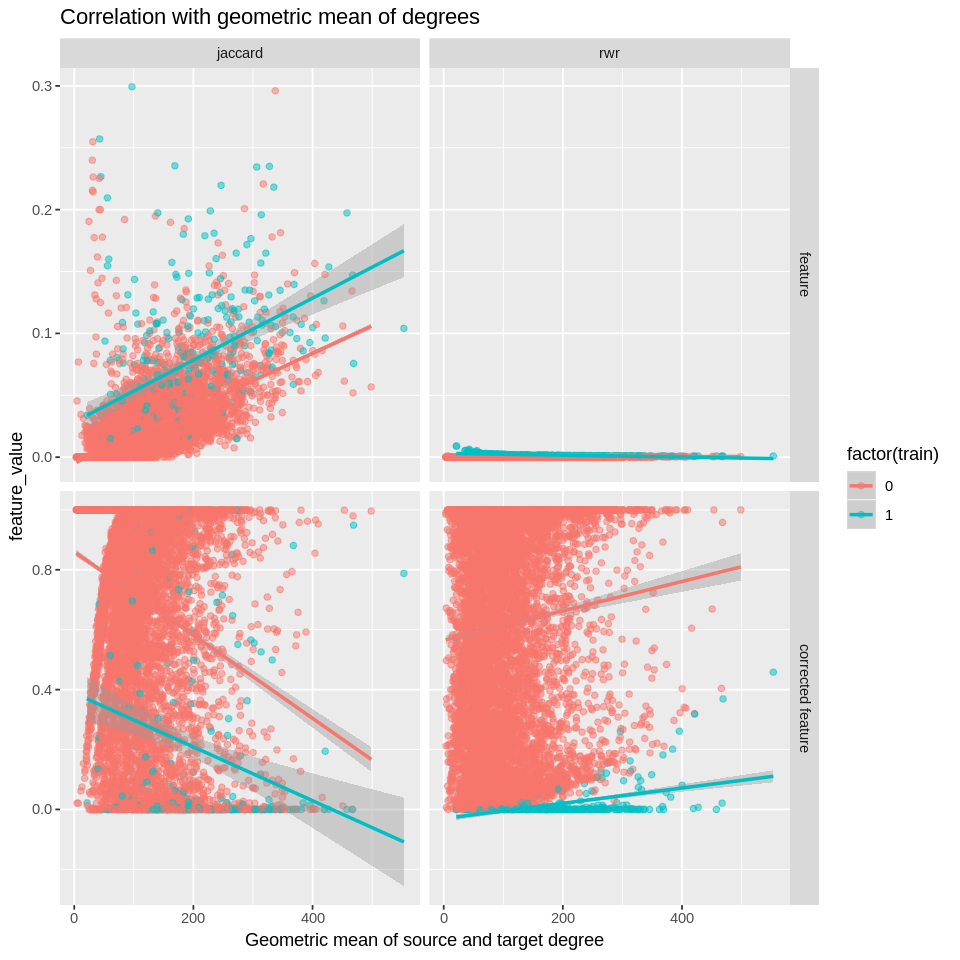

In [112]:
options(repr.plot.width=8, repr.plot.height=8)

(
    ggplot(degree_df %>% filter(degree_side == 'geometric mean degree'), aes(x = degree, y = feature_value, color = factor(train)))
    + geom_point(alpha=0.5)
    + geom_smooth(method='lm')
    + facet_grid(cols = vars(feature_name), rows = vars(feature_type), scales='free')
    + xlab('Geometric mean of source and target degree')
    + ggtitle("Correlation with geometric mean of degrees")
)

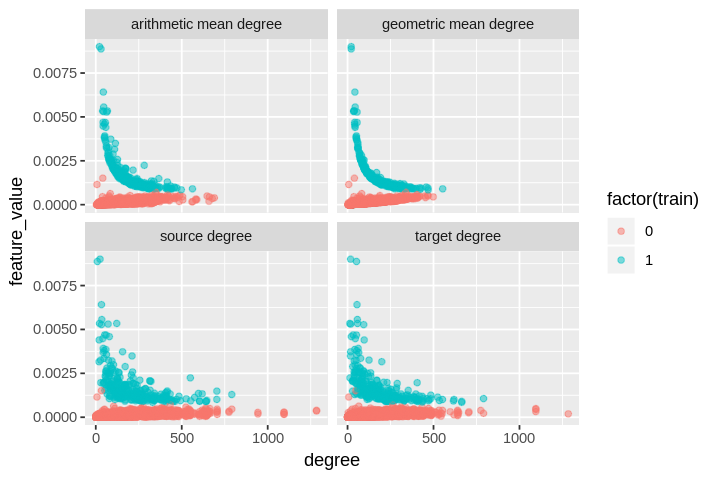

In [108]:
# RWR values are very strongly influenced by the existence of an edge
options(repr.plot.width=6, repr.plot.height=4)

(
    ggplot(degree_df %>% 
           filter(feature_name == 'rwr' & feature_type == 'feature'), 
           aes(x = degree, y = feature_value, color=factor(train)))
    + geom_point(alpha=0.5)
    + facet_wrap('degree_side')
)